# Machine Learning for Finance in Python

## Chapter 2

In [16]:
from datetime import datetime
import talib
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt

In [30]:
start_date_string = "2016-04-15"
end_date_string = "2018-04-10"

lng_df_all = pd.read_csv("LNG.csv")
lng_df_all.set_index("Date", inplace=True)
lng_df = lng_df_all.loc[start_date_string:end_date_string].copy()

spy_df_all = pd.read_csv("SPY.csv")
spy_df_all.set_index("Date", inplace=True)
spy_df = spy_df_all.loc[start_date_string:end_date_string].copy()

lng_df.index = pd.to_datetime(lng_df.index)

print(lng_df)
print(spy_df)

            Adj_Close  Adj_Volume
Date                             
2016-04-15      37.13   4293775.0
2016-04-18      36.90   3445852.0
2016-04-19      37.12   3748050.0
2016-04-20      37.77   2470384.0
2016-04-21      37.21   2043988.0
...               ...         ...
2018-04-04      54.30   1816771.0
2018-04-05      56.21   2533635.0
2018-04-06      54.36   1754446.0
2018-04-09      54.10   1203998.0
2018-04-10      55.63   3430268.0

[500 rows x 2 columns]
             Adj_Close   Adj_Volume
Date                               
2016-04-15  199.760673   75761600.0
2016-04-18  201.164330   75277700.0
2016-04-19  201.798846   88316100.0
2016-04-20  201.991139   81100300.0
2016-04-21  200.904747   85695000.0
...                ...          ...
2018-04-04  263.560000  123574054.0
2018-04-05  265.640000   80993290.0
2018-04-06  259.720000  179483634.0
2018-04-09  261.000000  105442932.0
2018-04-10  265.150000  105383213.0

[500 rows x 2 columns]


In [31]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = lng_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.164861
5d_close_future_pct     -0.164861             1.000000


In [32]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Create the moving average indicator and divide by Adj_Close
    lng_df['ma' + str(n)] = talib.SMA(lng_df['Adj_Close'].values,
                              timeperiod=n) / lng_df["Adj_Close"]
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(lng_df['Adj_Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


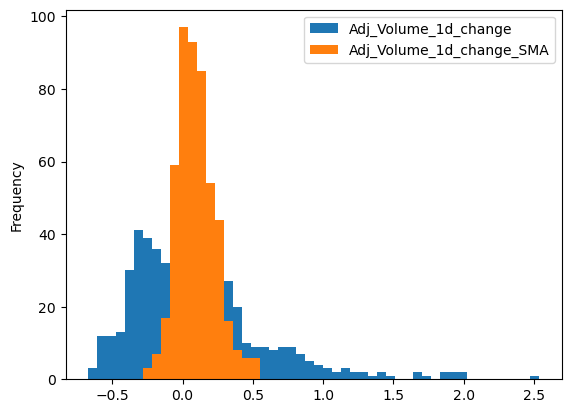

In [33]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
lng_df["Adj_Volume_1d_change"] = lng_df['Adj_Volume'].pct_change()
lng_df['Adj_Volume_1d_change_SMA'] = talib.SMA(lng_df["Adj_Volume_1d_change"].values,
                        timeperiod=5)

# Plot histogram of volume % change data
lng_df[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()

In [34]:
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(lng_df.index.dayofweek,
                              prefix="weekday",
                              drop_first=True,
                              dtype=int)

# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe
lng_df = pd.concat([lng_df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng_df.dropna(inplace=True)  # drop missing values in-place
print(lng_df.head())

            Adj_Close  Adj_Volume  5d_future_close  5d_close_future_pct  \
Date                                                                      
2017-01-31      47.65   2137394.0            47.81             0.003358   
2017-02-01      47.10   2051631.0            48.01             0.019321   
2017-02-02      49.33   3081369.0            49.19            -0.002838   
2017-02-03      49.43   4158130.0            48.93            -0.010115   
2017-02-06      48.50   2090909.0            48.14            -0.007423   

            5d_close_pct      ma14      rsi14      ma30      rsi30      ma50  \
Date                                                                           
2017-01-31      0.043812  0.950697  62.968946  0.918657  60.655749  0.895731   
2017-02-01     -0.023429  0.967486  60.156019  0.932427  59.159791  0.910110   
2017-02-02     -0.021618  0.932220  66.659314  0.895486  62.988478  0.873379   
2017-02-03      0.007336  0.938976  66.920059  0.899461  63.148741  0.8754

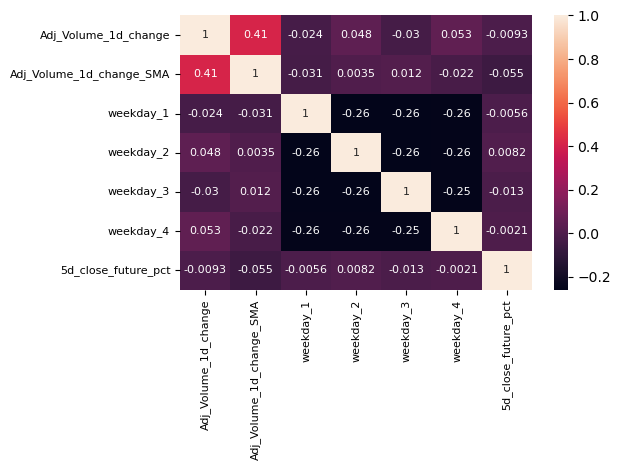

In [35]:
# Add the weekday labels to the new_features list
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

# Plot the correlations between the new features and the targets
sns.heatmap(lng_df[new_features+ ['5d_close_future_pct']].corr(), annot=True, annot_kws = {"size": 8})
plt.yticks(rotation=0, size = 8)# ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90, size = 8)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

Even though the correlations are weak, they may improve our predictions via interactions with other features.